## Ví dụ 1

C1:

In [2]:
# generate data 
# list of points  
import numpy as np  
np.random.seed(21) 
 
means = [[2, 2], [4, 1]] 
cov = [[.3, .2], [.2, .3]] 
N = 10 
X0 = np.random.multivariate_normal(means[0], cov, N) 
X1 = np.random.multivariate_normal(means[1], cov, N) 
X1[-1, :] = [2.7, 2] 
X0[-1, :] = [4.5, 1.2] 
X = np.concatenate((X0.T, X1.T), axis = 1) 
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

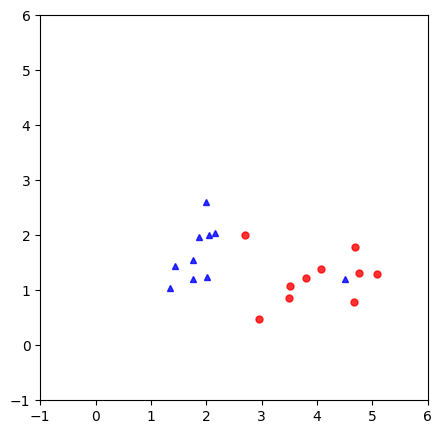

In [3]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(5, 5))   
 
ani = plt.cla() 
#plot points 
ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8) 
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8) 
ani = plt.axis([-1 , 6, -1, 6]) 
plt.show()

In [4]:
from cvxopt import matrix, solvers 
C = 100 
# build K 
V = np.concatenate((X0.T, -X1.T), axis = 1) 
# K ~ P in lib cvxopt.qp 
K = matrix(V.T.dot(V)) 
 
q = matrix(-np.ones((2*N, 1))) 
# build A, b, G, h  
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N)))) 
 
h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1))))) 
A = matrix(y.reshape((-1, 2*N)))  
b = matrix(np.zeros((1, 1)))  
solvers.options['show_progress'] = False 
sol = solvers.qp(K, q, G, h, A, b) 
 
l = np.array(sol['x']) 
print('lambda = \n', l.T)

lambda = 
 [[1.23267347e-07 4.85674336e+01 9.99999981e+01 1.57381885e-07
  1.40373846e-07 5.28974755e-08 4.87560152e-07 1.81225362e-07
  9.27217960e-08 1.00000000e+02 9.01112775e-08 5.15612516e-08
  3.58687179e-07 3.18585409e-07 7.07041178e-07 9.76857085e+01
  6.09091270e-08 5.08817211e+01 1.76779299e-06 9.99999999e+01]]


In [22]:
X.shape

(2, 20)

In [23]:
S = np.where(l > 1e-5)[0] # support set  
S2 = np.where(l < .999*C)[0]  
 
M = [val for val in S if val in S2] # intersection of two lists 
 
XT = X.T # we need each column to be one data point in this alg 
VS = V[:, S] 
lS = l[S] 
yM = y[0][M]

XM = X[:, M] 
 
w_dual = VS.dot(lS).reshape(-1, 1) 
b_dual = np.mean(yM.T - w_dual.T.dot(XM)) 
print(w_dual.T, b_dual)

[[-1.06640598  1.01378208]] 1.662390577003911


C2:

In [10]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data 
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data  
 
Z = np.hstack((X0_bar, - X1_bar)) # as in (22) 
lam = 1./C 
 
def cost(w): 
    u = w.T.dot(Z) # as in (23) 
    return (np.sum(np.maximum(0, 1 - u)) + .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias  
 
def grad(w): 
    u = w.T.dot(Z) # as in (23) 
    H = np.where(u < 1)[1] 
    ZS = Z[:, H] 
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w) 
    g[-1] -= lam*w[-1] # no weight decay on bias 
    return g 
 
eps = 1e-6

In [11]:
def grad_descent(w0, eta): 
    w = w0 
    it = 0  
    while it < 100000: 
        it = it + 1 
        g = grad(w) 
        w -= eta*g 
        if (it % 10000) == 1: 
            print('iter %d' %it + ' cost: %f' %cost(w)) 
        if np.linalg.norm(g) < 1e-5: 
            break  
    return w

In [12]:
w0 = np.random.randn(X0_bar.shape[0], 1)  
w = grad_descent(w0, 0.001) 
w_hinge = w[:-1].reshape(-1, 1) 
b_hinge = w[-1] 
print(w_hinge.T, b_hinge)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12768\1433431714.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('iter %d' %it + ' cost: %f' %cost(w))


iter 1 cost: 24.312820
iter 10001 cost: 4.963527
iter 20001 cost: 4.969327
iter 30001 cost: 4.961336
iter 40001 cost: 4.961370
iter 50001 cost: 4.961404
iter 60001 cost: 4.961438
iter 70001 cost: 4.969322
iter 80001 cost: 4.969296
iter 90001 cost: 4.969269
[[-1.07049082  0.99874462]] [1.68169917]


C3:

In [25]:
from sklearn.svm import SVC 
# Copy and put code for generate data here 
y1 = y.reshape((2*N,)) 
X1 = X.T # each sample is one row 
clf = SVC(kernel = 'linear', C = 100) # use the same C 
# if C is small, method will be “SoftMagin SVM”,  
# if C is large enough, method is near to hard margin 
clf.fit(X1, y1)  
 
w = clf.coef_ 
w0 = clf.intercept_ 
print('w = ', w) 
print('b = ', w0)

w =  [[-1.06600888  1.01354038]]
b =  [1.66151836]


- Cả 3 phương pháp đều cho bộ trọng số gần nhau

## Bài tập thực hành 1

Accuracy: 0.9


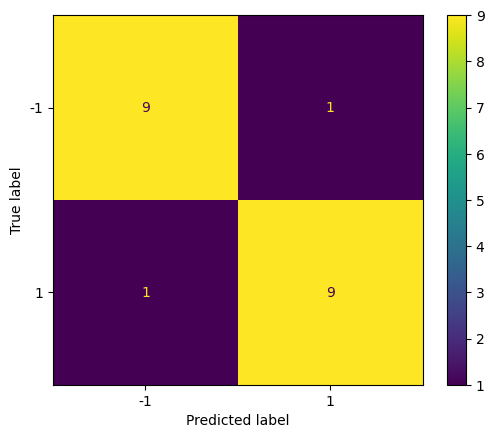

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

y_pred = clf.predict(X.T)

ConfusionMatrixDisplay.from_predictions(y.astype('int').squeeze(), y_pred)
print(f"Accuracy: {accuracy_score(y.astype('int').squeeze(), y_pred)}")

w =  [[-1.06653242  1.01479775]]
b =  [1.66176304]
Accuracy: 0.9


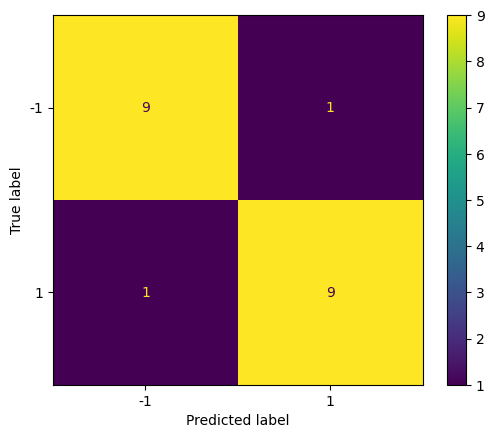

In [40]:
# C = 1000
X_train = X.T
y_train = y.astype('int').squeeze()
clf = SVC(kernel = 'linear', C = 1000) # use the same C 
clf.fit(X_train, y_train)  
w = clf.coef_ 
w0 = clf.intercept_ 
print('w = ', w) 
print('b = ', w0)

y_pred = clf.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")

w =  [[-1.06696752  1.01310859]]
b =  [1.66454149]
Accuracy: 0.9


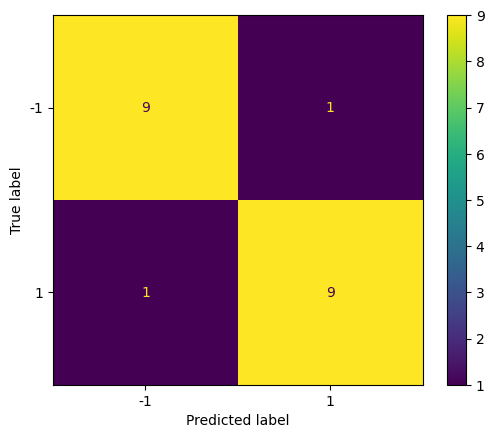

In [41]:
# C = 200
X_train = X.T
y_train = y.astype('int').squeeze()
clf = SVC(kernel = 'linear', C = 200) # use the same C 
clf.fit(X_train, y_train)  
w = clf.coef_ 
w0 = clf.intercept_ 
print('w = ', w) 
print('b = ', w0)

y_pred = clf.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")

w =  [[-1.10103939  0.51083347]]
b =  [2.3258627]
Accuracy: 0.9


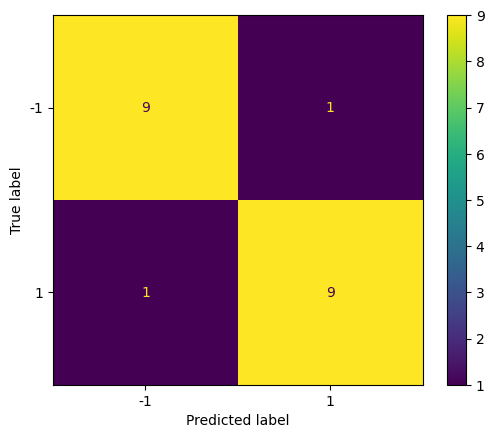

In [42]:
# C = 10
X_train = X.T
y_train = y.astype('int').squeeze()
clf = SVC(kernel = 'linear', C = 10) # use the same C 
clf.fit(X_train, y_train)  
w = clf.coef_ 
w0 = clf.intercept_ 
print('w = ', w) 
print('b = ', w0)

y_pred = clf.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")

w =  [[-1.01747184  0.54544914]]
b =  [2.07460967]
Accuracy: 0.9


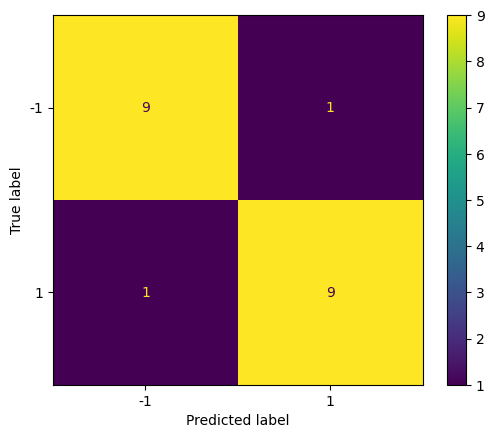

In [43]:
# C = 0.5
X_train = X.T
y_train = y.astype('int').squeeze()
clf = SVC(kernel = 'linear', C = 0.5) # use the same C 
clf.fit(X_train, y_train)  
w = clf.coef_ 
w0 = clf.intercept_ 
print('w = ', w) 
print('b = ', w0)

y_pred = clf.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")

## Bài tập thực hành 2

In [44]:
from sklearn import datasets

cancer_data = datasets.load_breast_cancer() 
 
# show to test record 5th 
print(cancer_data.data[5]) 
 
print(cancer_data.data.shape) 
#target set 
print(cancer_data.target) 
 
from sklearn.model_selection import train_test_split 
  
cancer_data = datasets.load_breast_cancer() 
  
X_train, X_test, y_train, y_test = train_test_split(cancer_data.data,  
     cancer_data.target,  
     test_size=0.3,random_state=109)

[1.245e+01 1.570e+01 8.257e+01 4.771e+02 1.278e-01 1.700e-01 1.578e-01
 8.089e-02 2.087e-01 7.613e-02 3.345e-01 8.902e-01 2.217e+00 2.719e+01
 7.510e-03 3.345e-02 3.672e-02 1.137e-02 2.165e-02 5.082e-03 1.547e+01
 2.375e+01 1.034e+02 7.416e+02 1.791e-01 5.249e-01 5.355e-01 1.741e-01
 3.985e-01 1.244e-01]
(569, 30)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 

Accuracy: 0.9824561403508771


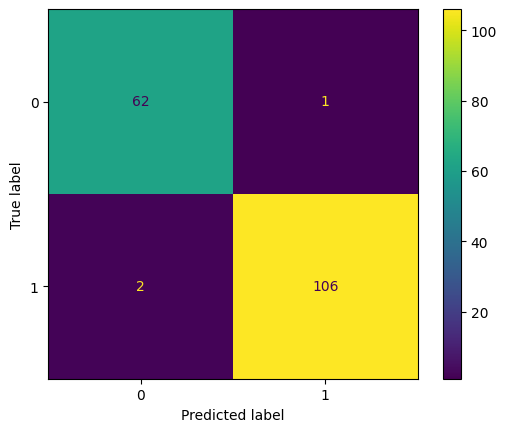

In [45]:
clf = SVC(kernel='linear', C=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

## Ví dụ 2

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('sonar.all-data.csv', header=None)
X, y = data.iloc[:, :60], data.iloc[:, 60]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

Accuracy: 0.7380952380952381


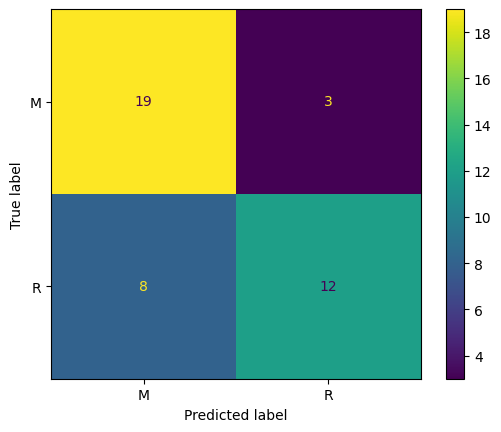

In [49]:
clf = SVC(kernel='linear', C=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

## Ví dụ 3

In [50]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 
  
# metadata 
print(spambase.metadata) 
  
# variable information 
print(spambase.variables) 

{'uci_id': 94, 'name': 'Spambase', 'repository_url': 'https://archive.ics.uci.edu/dataset/94/spambase', 'data_url': 'https://archive.ics.uci.edu/static/public/94/data.csv', 'abstract': 'Classifying Email as Spam or Non-Spam', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 4601, 'num_features': 57, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C53G6X', 'creators': ['Mark Hopkins', 'Erik Reeber', 'George Forman', 'Jaap Suermondt'], 'intro_paper': None, 'additional_info': {'summary': 'The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography...\n\nThe classification task for this dataset is to determine whether a given email is spam or not.\n\t\nOur collecti

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy: 0.9158385093167701
Accuracy: 0.9094858797972484


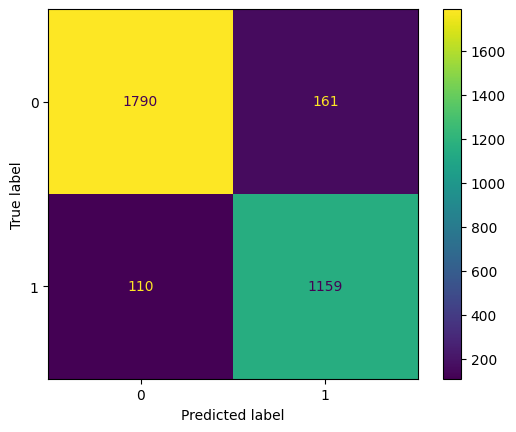

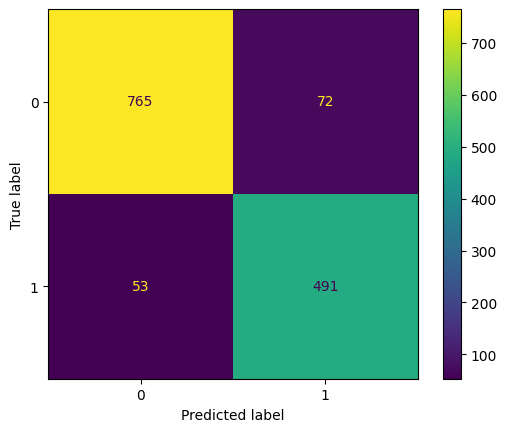

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)

clf = SVC(kernel='linear', C=1000)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train)}")

y_pred_test = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")

## Ví dụ 5

In [59]:
data = pd.read_csv('Admission_Predict.csv')
data.drop('Serial No.', axis=1, inplace=True)
data['Admission'] = data['Chance of Admit'].apply(lambda x: 1 if x > 0.5 else 0)
data.drop('Chance of Admit', axis=1, inplace=True)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)

Train Accuracy: 0.9285714285714286
Accuracy: 0.8833333333333333


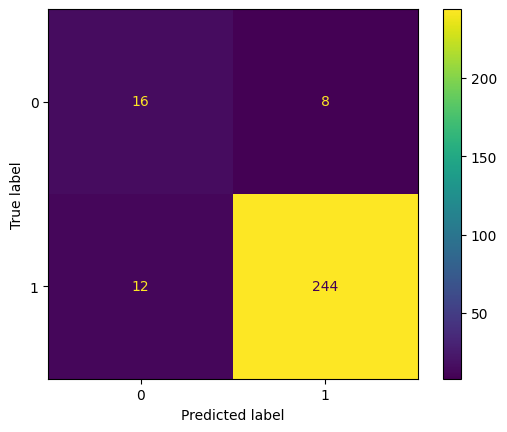

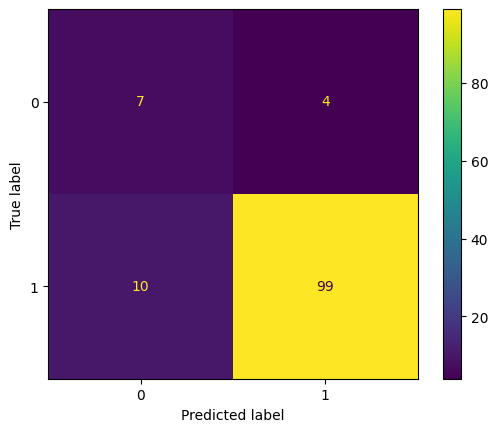

In [60]:
clf = SVC(kernel='linear', C=1000)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train)}")

y_pred_test = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 0.9178571428571428
Accuracy: 0.9083333333333333


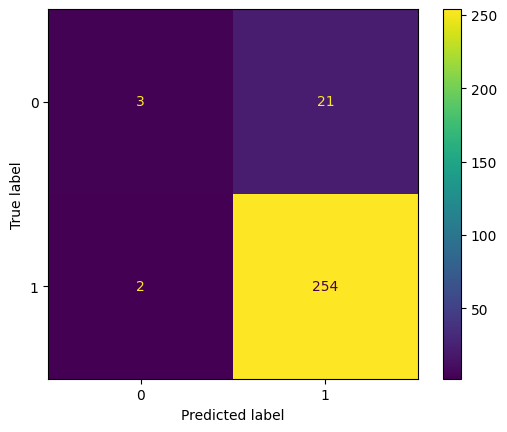

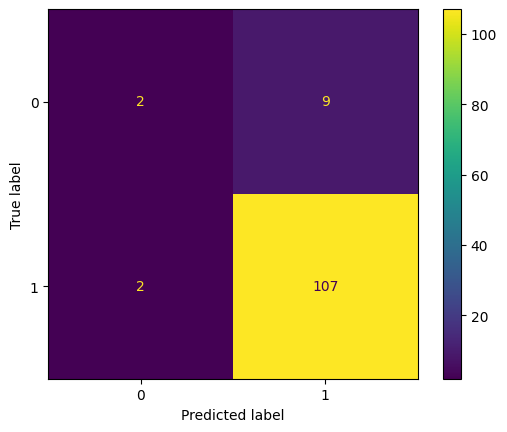

In [61]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train)}")

y_pred_test = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")

- Cả 2 phương pháp SVM soft margin và Logistic regression cho kết quả khá tương đồng